# Topdesk changes analyse

Dit notebook bevat verschillende grafieken met betrekking tot de gespendeerde tijd aan changes

In [22]:
import pandas as pd

import topdesk

FIGURES_DIRECTORY = "../figures"

## Ophalen gegevens

In [23]:
query = [
    "operatorGroup.name=='Expertteam - Networking'",
    "status.name=='Afgerond'",
    "creationDate=ge=2020-01-01T00:00:00Z",
    "creationDate=le=2022-01-01T00:00:00Z",
    "archived==false"
]

fields = [
    "timeSpent",
    "category.name",
    "subcategory.name",
    "creationDate",
    "finalDate"
]

results = topdesk.get_changeactivities(query, fields)

## Data cleaning

drop nan values, filter op alleen de 'netwerk' categorie en converteer de 'creationDate' kolom naar `DateTime`

In [24]:
df = (pd.json_normalize(results)
        .dropna()
        .convert_dtypes()
        )

df = df.loc[df['category.name'] == 'Netwerk']

df.creationDate = pd.to_datetime(df.creationDate)

df.finalDate = pd.to_datetime(df.finalDate)

# df.timeSpent = df.timeSpent / 3600 # twee keer delen door 60 om naar uren te zetten

## Verloop gespendeerde tijd per categorie

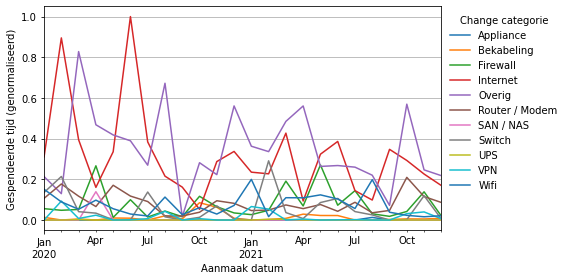

In [25]:
plot = (
    df
    .groupby([pd.Grouper(key='creationDate', freq='M'), 'subcategory.name'])
    .sum()
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    .pivot_table(values='timeSpent', columns='subcategory.name', index='creationDate')
    .fillna(0)
    .plot(kind='line', figsize=(8,4), xlabel='Aanmaak datum', ylabel='Gespendeerde tijd (genormaliseerd)')
    )
    
plot.grid(axis='y')
plot.legend(title='Change categorie', bbox_to_anchor=(1,1), loc="upper left", frameon=False)
fig = plot.get_figure()
fig.tight_layout()
fig.savefig(f'{FIGURES_DIRECTORY}/changes_tijd_categorie_tijd.pdf')

<AxesSubplot:xlabel='Aanmaak datum', ylabel='Gespendeerde tijd (genormaliseerd)'>

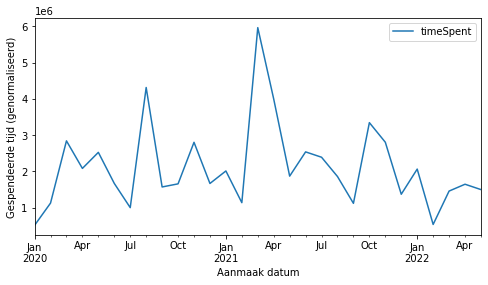

In [26]:
plot = (
    df
    .groupby([pd.Grouper(key='finalDate', freq='M')])
    .sum()
    # .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    .plot(kind='line', figsize=(8,4), xlabel='Aanmaak datum', ylabel='Gespendeerde tijd (genormaliseerd)')
    )

plot
    
# plot.grid(axis='y')
# plot.legend(title='Change categorie', bbox_to_anchor=(1,1), loc="upper left", frameon=False)
# fig = plot.get_figure()
# fig.tight_layout()
# fig.savefig(f'{FIGURES_DIRECTORY}/changes_tijd_categorie_tijd.pdf')

## Totale tijd besteed per categorie

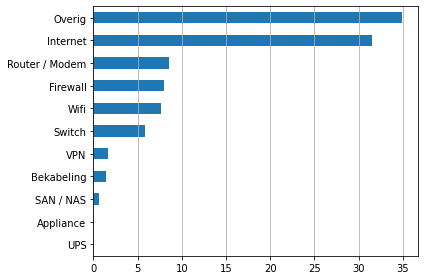

In [27]:
def normalize(s: pd.Series) -> pd.Series:
    return (s / s.sum()) * 100

plot = (
    df[['subcategory.name', 'timeSpent']]
    .groupby('subcategory.name')
    .sum()
    .apply(normalize)
    .sort_values(by='timeSpent', ascending=True)
    .plot(kind='barh', xlabel='', legend=False)
)

plot.grid(axis='x')
fig = plot.get_figure()
fig.tight_layout()
fig.savefig(f'{FIGURES_DIRECTORY}/changes_tijd_categorie.pdf')


# Gemiddelde tijd besteed per categorie

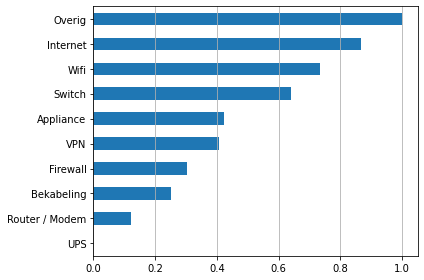

In [28]:
plot = (
    df[['subcategory.name', 'timeSpent']]
    [df['subcategory.name'] != 'SAN / NAS']
    .groupby('subcategory.name')
    .mean()
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))
    .sort_values(by='timeSpent')
    .plot(kind='barh', legend=False, xlabel='')
)

plot.grid(axis='x')
fig = plot.get_figure()
fig.tight_layout()
fig.savefig(f'{FIGURES_DIRECTORY}/changes_tijd_gemiddeld_categorie.pdf')

## Hoeveelheid changes per categorie

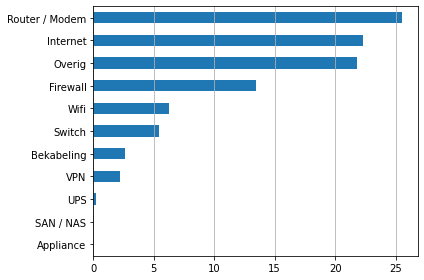

In [29]:
plot = (
    df['subcategory.name']
    .value_counts(normalize=True)
    .mul(100)
    .sort_values()
    .plot(kind='barh')
)

plot.grid(axis='x')
fig = plot.get_figure()
fig.tight_layout()
fig.savefig(f'{FIGURES_DIRECTORY}/changes_aantal_categorie.pdf')